In [3]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

## Подготавливаем данные

In [34]:
df = pd.read_csv('wiki_machine_learning.csv', sep = ' ')
df.head()
#print(df.shape)

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [35]:
df = df[df['count'] != 0]
df.head()
#print(df.shape)

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [7]:
df.shape

(383, 7)

## Предсказываем с помощью ARIMA

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [10]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

Критерий Дики-Фуллера: p=0.107392


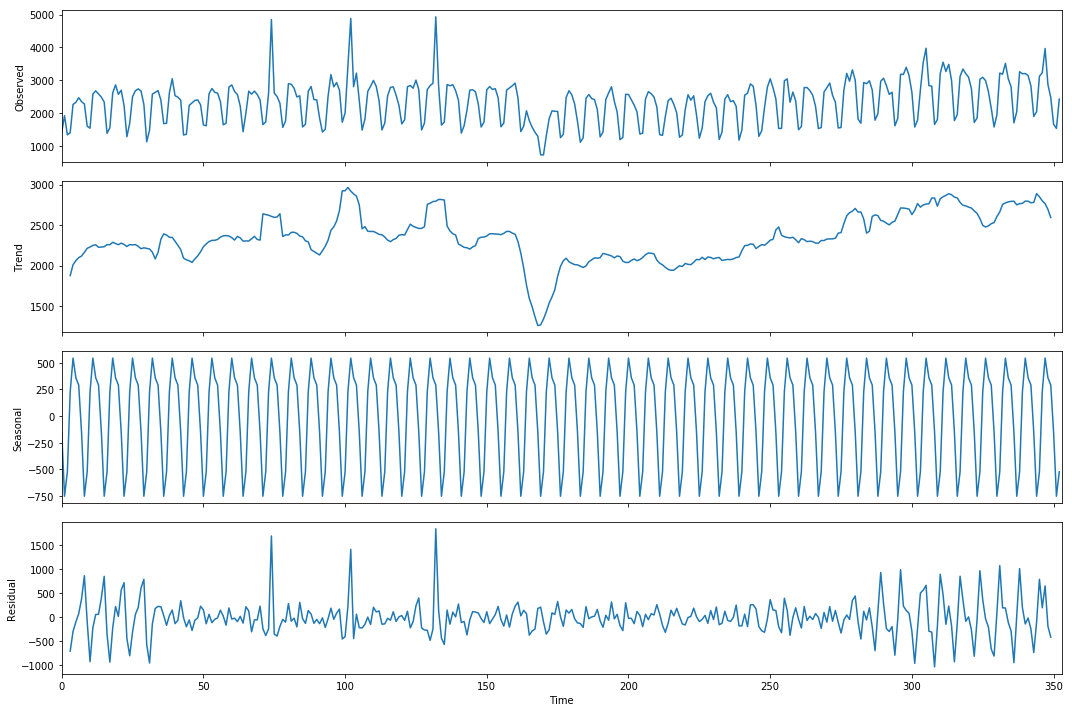

In [11]:
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

А вот сезонно продифференцированный ряд уже будет стационарным.

In [12]:
train_df.set_index('ds', inplace=True)

Критерий Дики-Фуллера: p=0.000000


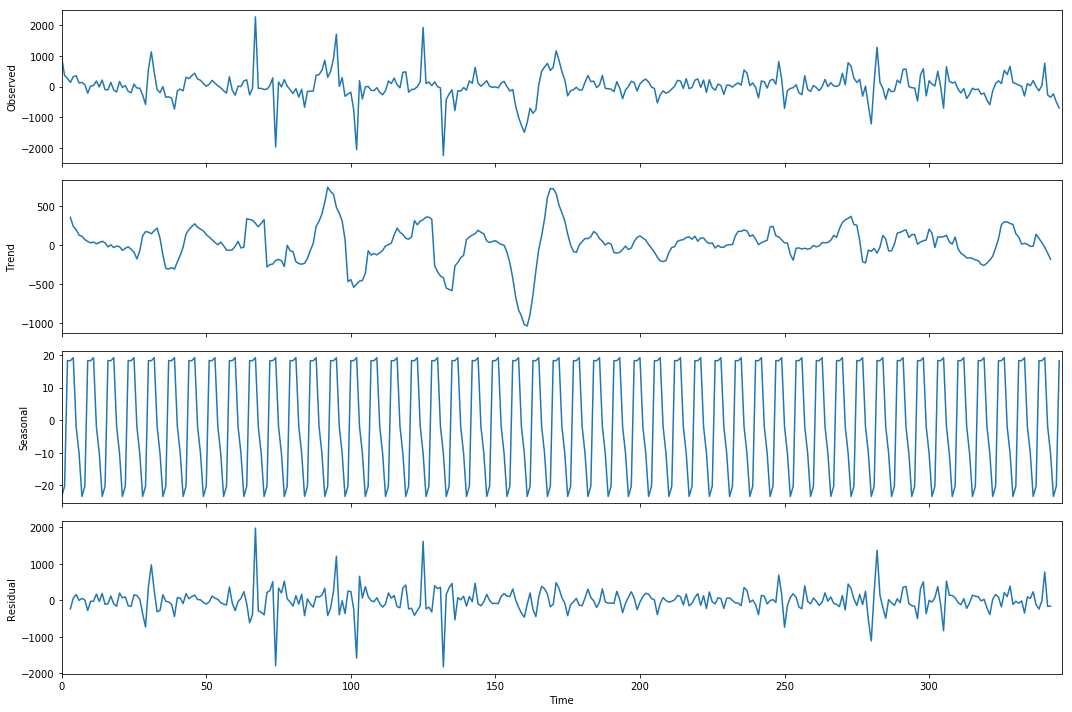

In [13]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

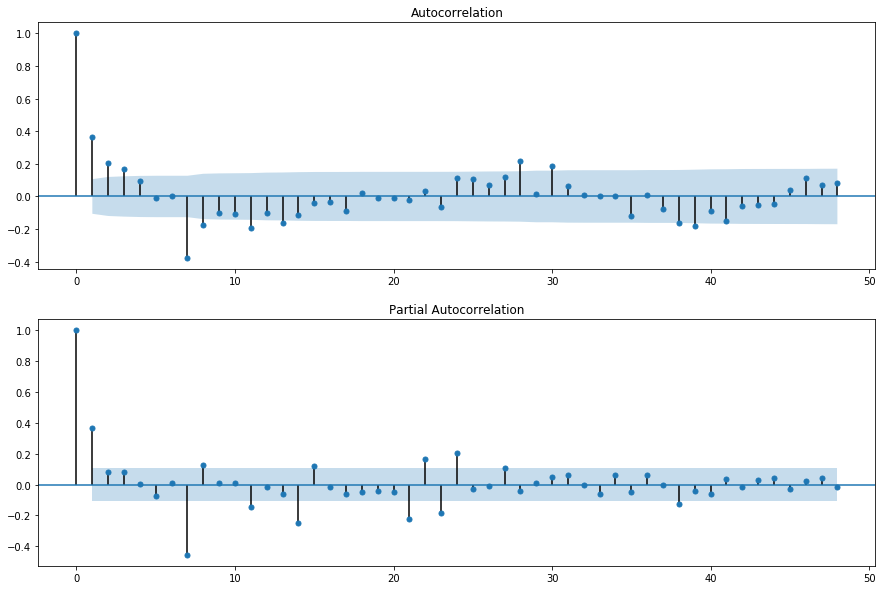

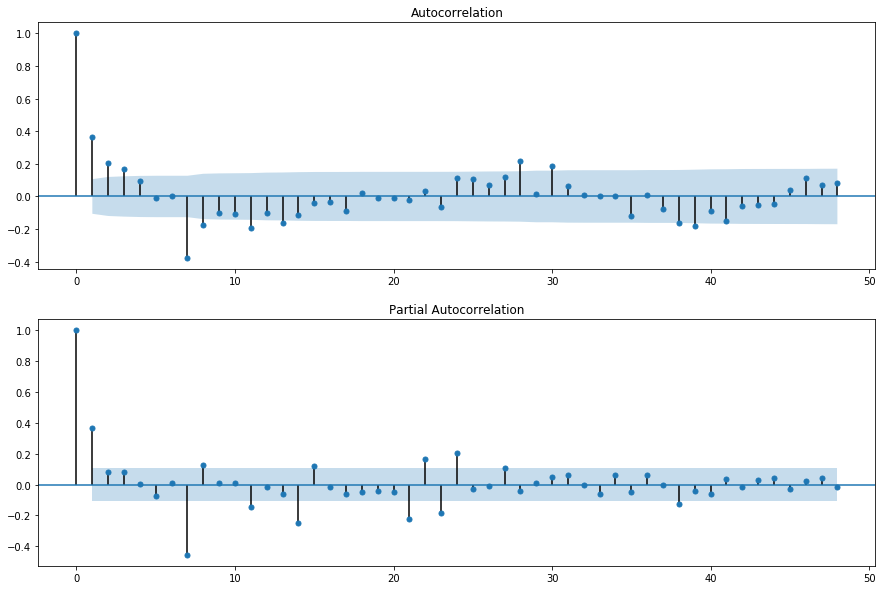

In [14]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

Начальные приближения:
* Q = 1
* q = 3
* P = 3
* p = 1

In [15]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [38]:
from itertools import product
parameters = product(ps, ds, qs, Ps, Ds, Qs)

In [43]:
parameters

In [36]:
parameters_list = list(parameters)
len(parameters_list)

384

In [18]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [22:35<00:00,  3.53s/it]


Wall time: 22min 35s


In [19]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
137  (0, 1, 2, 3, 2, 1)  4961.632628
269  (1, 1, 1, 3, 2, 1)  4962.830672
159  (0, 1, 3, 3, 2, 1)  4969.534608
180  (1, 0, 0, 3, 2, 1)  4973.212241
77   (0, 0, 3, 3, 2, 1)  4978.036900


Если рассматривать предложенные в форме варианты:

In [20]:
result_table1[result_table1['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])]

,parameters,aic
212,"(1, 0, 2, 3, 1, 0)",5022.312524
282,"(1, 1, 2, 3, 1, 1)",5019.555903
284,"(1, 1, 2, 3, 2, 1)",4988.975976


Теперь то же самое, но для ряда с преобразованием Бокса-Кокса.

In [21]:
import scipy.stats
train_df['y_box'], lmbda = scipy.stats.boxcox(train_df['y']) 
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.732841


In [22]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y_box'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [16:31<00:00,  2.58s/it]


In [23]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
222  (1, 0, 2, 3, 2, 1)  3528.650805
180  (1, 0, 0, 3, 2, 1)  3530.524249
201  (1, 0, 1, 3, 2, 1)  3532.092279
276  (1, 1, 1, 3, 2, 1)  3534.434779
291  (1, 1, 2, 3, 2, 1)  3534.540192


Если рассматривать предложенные в форме варианты:

In [24]:
result_table2[result_table2['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])].sort_values(by = 'aic')

,parameters,aic
291,"(1, 1, 2, 3, 2, 1)",3534.540192
219,"(1, 0, 2, 3, 1, 0)",3556.880030
289,"(1, 1, 2, 3, 1, 1)",3557.840004


**Вопрос 5**: Модель SARIMAX c какими параметрами лучшая по AIC-критерию?

**Ответ:** из предложенных вариантов подходят первый (D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1) и второй (D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1) в зависимости от того, делать ли вначале преобразование Бокса-Кокса или нет.

Посмотрим на прогноз лучшей по AIC модели.

In [25]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, 1, 7)   Log Likelihood               -1756.325
Date:                           Thu, 09 Aug 2018   AIC                           3528.651
Time:                                   07:21:32   BIC                           3559.259
Sample:                                        0   HQIC                          3540.848
                                           - 353                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8195      0.118      6.958      0.000       0.589       1.050
ma.L1         -0.3354      0.124     -2.702

Критерий Стьюдента: p=0.114833
Критерий Дики-Фуллера: p=0.000000


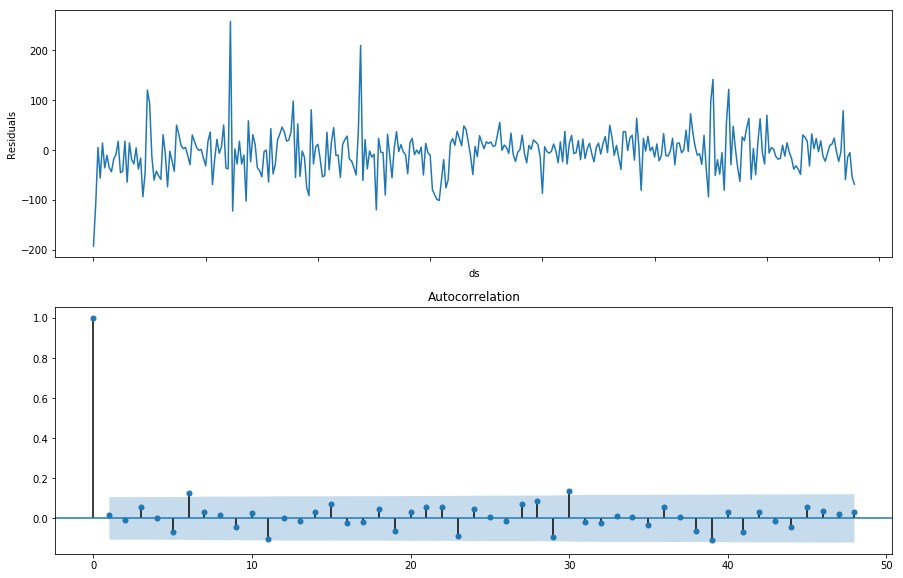

In [26]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [27]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

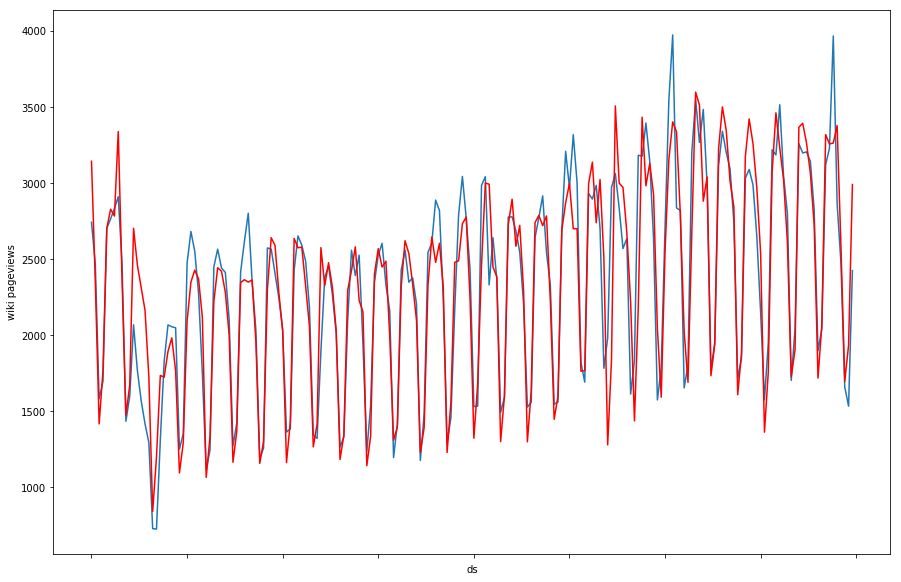

In [28]:
train_df['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)

train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color='r')
plt.ylabel('wiki pageviews');

# Setting up ARIMA

In [ ]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [ ]:
%%time
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some 
        # combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(
                    ads.Ads, order=(param[0], d, param[1]), 
                    seasonal_order=(
                        param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, 
    # the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', 
                        ascending=True).reset_index(drop=True)
    
    return result_table
    
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

In [ ]:
ts_plot.tsplot(best_model.resid[24+1:], lags=60)

Plotting prediction of the chosen model

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    
plotSARIMA(ads, best_model, 50)
